✅ Connexion réussie.
Nombre d'équipements récupérés: 770
   ID Equipment_ID                     Equipment_Name Maintenance_Cycle  \
0   1        E3802                Machine d'Emballage     Trimestrielle   
1   2        E5348  Système de Refroidissement Rapide     Trimestrielle   
2   3        E3247                Machine d'Emballage     Unknown Cycle   
3   4        E1979         Ligne de Production Yaourt       Bimensuelle   
4   5        E1988             Machine de Remplissage         Mensuelle   

          Category Energy_Type Maintenance_Frequency Location  \
0  Quality Control         Gas           Trimestriel    Tunis   
1     Conditioning        Fuel               Mensuel    Gabès   
2   Transformation     Unknown           Trimestriel   Sousse   
3  Quality Control     Unknown                Annuel    Gabès   
4         Cleaning       Solar                Annuel    Tunis   

    CO2_Emissions_kg Estimated_Lifetime_Years Energy_Consumption_kWh  
0  141.8053714479979          

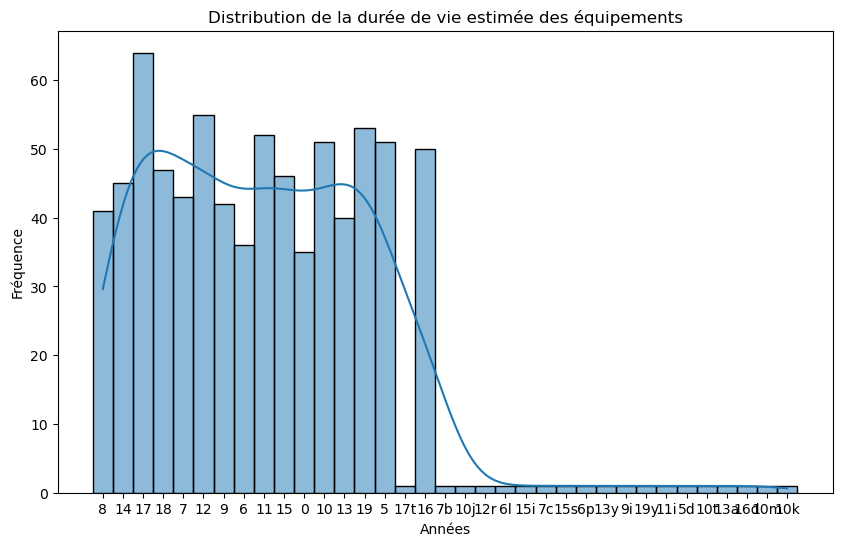

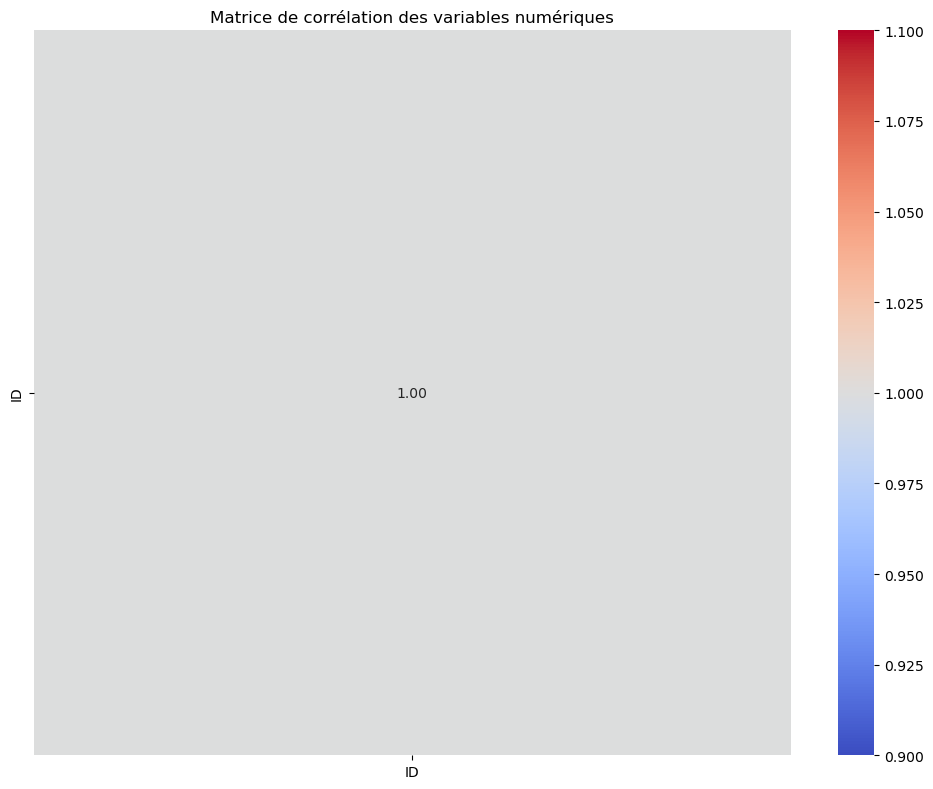


Nombre de lignes après nettoyage: 770
Nombre de lignes après suppression des cibles manquantes: 770

Taille de l'ensemble d'entraînement: 616 lignes
Taille de l'ensemble de test: 154 lignes

--- Entraînement du modèle Ridge ---


ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: '570.7880n'

In [1]:
# Partie 1: Connexion à la base de données
import pyodbc
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Connexion à la base de données via ODBC
try:
    conn = pyodbc.connect(
        'DRIVER={ODBC Driver 17 for SQL Server};'
        'SERVER=ASSSOUMA\\SQLEXPRESS;'
        'DATABASE=SAP_DW;'
        'UID=sa;'
        'PWD=123456'
    )
    print("✅ Connexion réussie.")
except pyodbc.Error as e:
    print("❌ Échec de la connexion :", e)

# Partie 2: Récupération des données avec un échantillon plus large
# Modifié pour récupérer toutes les données disponibles au lieu des 10 premières lignes
query = "SELECT * FROM Dim_Equipements;"
df = pd.read_sql(query, conn)

print(f"Nombre d'équipements récupérés: {len(df)}")
print(df.head())

# Partie 3: Analyse exploratoire des données
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Vérification des valeurs manquantes
print("\nVérification des valeurs manquantes:")
print(df.isnull().sum())

# Traitement des valeurs manquantes ou problématiques
# Remplacer les valeurs 'Unknown' par NaN pour traitement uniforme
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].replace('Unknown', np.nan)
        df[col] = df[col].replace('Unknown Cycle', np.nan)

# Afficher les statistiques descriptives
print("\nStatistiques descriptives de la variable cible:")
print(df['Estimated_Lifetime_Years'].describe())

# Visualisation de la distribution de la variable cible
plt.figure(figsize=(10, 6))
sns.histplot(df['Estimated_Lifetime_Years'], kde=True)
plt.title('Distribution de la durée de vie estimée des équipements')
plt.xlabel('Années')
plt.ylabel('Fréquence')
plt.show()

# Vérification des corrélations
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation des variables numériques')
plt.tight_layout()
plt.show()

# Partie 4: Préparation des données pour la modélisation
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

# Sélection des caractéristiques plus pertinentes - réduction de la dimensionnalité
# Éviter d'utiliser Equipment_Name et Equipment_ID qui sont trop spécifiques
categorical_features = ['Category', 'Maintenance_Cycle', 'Location', 'Energy_Type', 'Maintenance_Frequency']
numeric_features = ['CO2_Emissions_kg', 'Energy_Consumption_kWh']

# Définir la variable cible
target = 'Estimated_Lifetime_Years'

# Vérifier les données avant division
print("\nNombre de lignes après nettoyage:", len(df))

# Supprimer les lignes où la variable cible est manquante
df = df.dropna(subset=[target])
print("Nombre de lignes après suppression des cibles manquantes:", len(df))

# Séparer les caractéristiques et la cible
X = df[categorical_features + numeric_features]
y = df[target]

# Vérifier s'il y a suffisamment de données
if len(df) < 50:
    print("\n⚠️ AVERTISSEMENT: Le jeu de données est très petit (<50 lignes).")
    print("Les performances du modèle seront probablement limitées.")

# Diviser les données en ensembles d'entraînement et de test avec un ratio adapté à la taille
test_size = 0.2 if len(df) >= 100 else 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print(f"\nTaille de l'ensemble d'entraînement: {len(X_train)} lignes")
print(f"Taille de l'ensemble de test: {len(X_test)} lignes")

# Créer un préprocesseur amélioré pour transformer les données
# Ajout d'une étape d'imputation pour gérer les valeurs manquantes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ])

# Partie 5: Modélisation avec régularisation pour éviter le surapprentissage
# Création d'une liste de modèles à tester
models = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
}

# Évaluation des différents modèles
results = {}

for name, model in models.items():
    # Créer un pipeline avec prétraitement et modèle
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Entraîner le modèle
    print(f"\n--- Entraînement du modèle {name} ---")
    pipeline.fit(X_train, y_train)
    
    # Évaluer le modèle sur l'ensemble d'entraînement
    train_score = pipeline.score(X_train, y_train)
    print(f"R² sur l'ensemble d'entraînement: {train_score:.4f}")
    
    # Évaluer le modèle sur l'ensemble de test
    test_score = pipeline.score(X_test, y_test)
    print(f"R² sur l'ensemble de test: {test_score:.4f}")
    
    # Faire des prédictions sur l'ensemble de test
    y_pred = pipeline.predict(X_test)
    
    # Calculer les métriques d'évaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    # Validation croisée avec gestion des erreurs
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    try:
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='r2')
        cv_mean = np.nanmean(cv_scores)  # Utiliser nanmean pour ignorer les NaN
        print(f"Scores de validation croisée (R²): {cv_scores}")
        print(f"Score moyen de validation croisée (R²): {cv_mean:.4f}")
    except Exception as e:
        print(f"Erreur lors de la validation croisée: {e}")
        cv_mean = float('nan')
    
    # Stocker les résultats
    results[name] = {
        'train_r2': train_score,
        'test_r2': test_score,
        'rmse': rmse,
        'mae': mae,
        'cv_mean': cv_mean,
        'pipeline': pipeline
    }

# Identifier le meilleur modèle
best_model_name = max(results, key=lambda x: results[x]['test_r2'])
best_model = results[best_model_name]['pipeline']

print(f"\n=== Le meilleur modèle est {best_model_name} ===")
print(f"R² sur l'ensemble de test: {results[best_model_name]['test_r2']:.4f}")
print(f"RMSE: {results[best_model_name]['rmse']:.4f}")

# Partie 6: Analyse du modèle et prédictions
print("\nExemple de prédiction pour un nouvel équipement:")

# Créer un DataFrame pour un nouvel équipement
new_equipment = pd.DataFrame({
    'Category': ['Conditionnement'],
    'Maintenance_Cycle': ['Mensuelle'],
    'Location': ['Sfax'],  # Ajusté pour correspondre aux données de formation
    'Energy_Type': ['Electricité'],
    'Maintenance_Frequency': ['Mensuel'],
    'CO2_Emissions_kg': [450.5],
    'Energy_Consumption_kWh': [2500.0]
})

# Faire une prédiction avec le meilleur modèle
predicted_lifetime = best_model.predict(new_equipment)
print(f"Durée de vie prédite pour le nouvel équipement: {predicted_lifetime[0]:.2f} années")

# Visualisation des prédictions vs réalité
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_model.predict(X_test), alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title(f'Prédictions vs Réalité avec {best_model_name}')
plt.show()

# Analyse de l'importance des caractéristiques pour RandomForest
if best_model_name == 'RandomForest':
    regressor = best_model.named_steps['regressor']
    feature_names = []
    
    # Obtenir les noms des caractéristiques après transformation
    # Pour les caractéristiques numériques
    feature_names.extend(numeric_features)
    
    # Pour les caractéristiques catégorielles encodées
    cat_encoder = best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder']
    if hasattr(cat_encoder, 'get_feature_names_out'):
        cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
        feature_names.extend(cat_feature_names)
    
    # Afficher l'importance des caractéristiques
    if hasattr(regressor, 'feature_importances_'):
        importances = regressor.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title('Importance des caractéristiques')
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), [feature_names[i] if i < len(feature_names) else f"Feature {i}" for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()
        
        print("\nLes 10 caractéristiques les plus importantes:")
        for i in range(min(10, len(indices))):
            feature_idx = indices[i]
            if feature_idx < len(feature_names):
                print(f"{feature_names[feature_idx]}: {importances[feature_idx]:.4f}")
            else:
                print(f"Feature {feature_idx}: {importances[feature_idx]:.4f}")

# Fermer la connexion à la base de données
conn.close()

In [2]:
# Partie 1: Connexion à la base de données
import pyodbc
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Connexion à la base de données via ODBC
try:
    conn = pyodbc.connect(
        'DRIVER={ODBC Driver 17 for SQL Server};'
        'SERVER=ASSSOUMA\\SQLEXPRESS;'
        'DATABASE=SAP_DW;'
        'UID=sa;'
        'PWD=123456'
    )
    print("✅ Connexion réussie.")
except pyodbc.Error as e:
    print("❌ Échec de la connexion :", e)

✅ Connexion réussie.


In [3]:
# Partie 2: Récupération des données avec un échantillon plus large
# Modifié pour récupérer toutes les données disponibles au lieu des 10 premières lignes
query = "SELECT * FROM Dim_Equipements;"
df = pd.read_sql(query, conn)

print(f"Nombre d'équipements récupérés: {len(df)}")
print(df.head())

Nombre d'équipements récupérés: 770
   ID Equipment_ID                     Equipment_Name Maintenance_Cycle  \
0   1        E3802                Machine d'Emballage     Trimestrielle   
1   2        E5348  Système de Refroidissement Rapide     Trimestrielle   
2   3        E3247                Machine d'Emballage     Unknown Cycle   
3   4        E1979         Ligne de Production Yaourt       Bimensuelle   
4   5        E1988             Machine de Remplissage         Mensuelle   

          Category Energy_Type Maintenance_Frequency Location  \
0  Quality Control         Gas           Trimestriel    Tunis   
1     Conditioning        Fuel               Mensuel    Gabès   
2   Transformation     Unknown           Trimestriel   Sousse   
3  Quality Control     Unknown                Annuel    Gabès   
4         Cleaning       Solar                Annuel    Tunis   

    CO2_Emissions_kg Estimated_Lifetime_Years Energy_Consumption_kWh  
0  141.8053714479979                        8      


Vérification des valeurs manquantes:
ID                          0
Equipment_ID                0
Equipment_Name              0
Maintenance_Cycle           0
Category                    0
Energy_Type                 0
Maintenance_Frequency       0
Location                    0
CO2_Emissions_kg            0
Estimated_Lifetime_Years    0
Energy_Consumption_kWh      0
dtype: int64

Statistiques descriptives de la variable cible:
count     770
unique     35
top        17
freq       64
Name: Estimated_Lifetime_Years, dtype: object


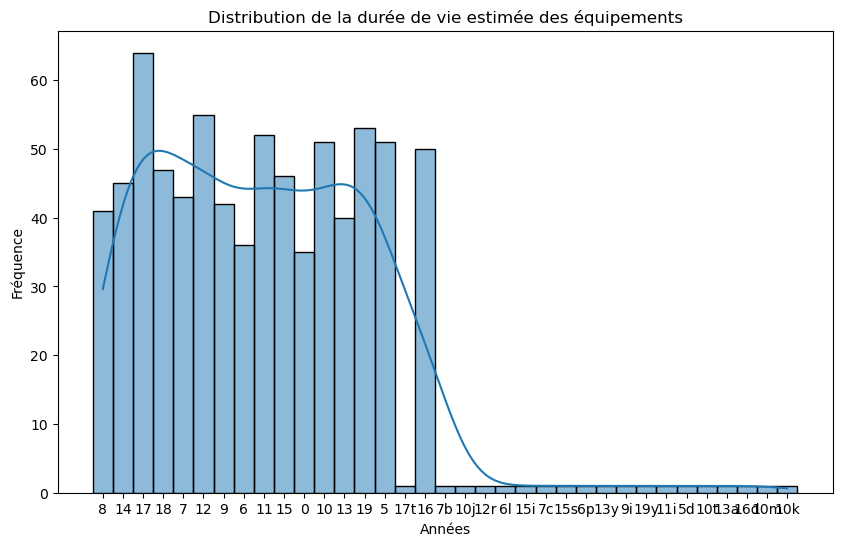

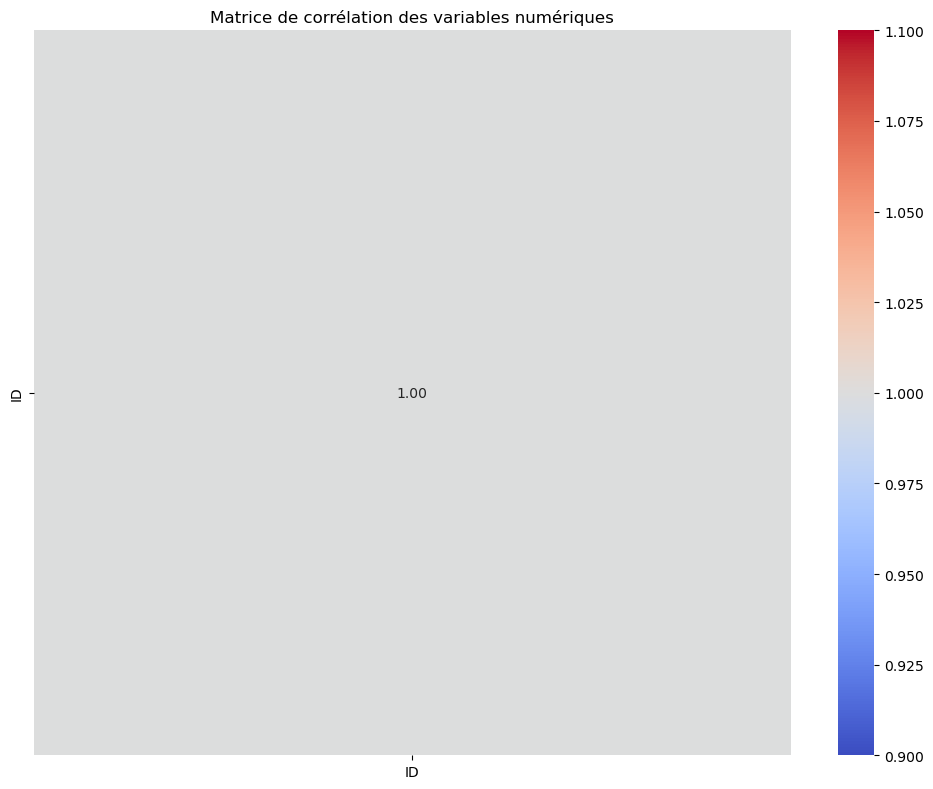

In [4]:
# Partie 3: Analyse exploratoire des données
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Vérification des valeurs manquantes
print("\nVérification des valeurs manquantes:")
print(df.isnull().sum())

# Traitement des valeurs manquantes ou problématiques
# Remplacer les valeurs 'Unknown' par NaN pour traitement uniforme
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].replace('Unknown', np.nan)
        df[col] = df[col].replace('Unknown Cycle', np.nan)

# Afficher les statistiques descriptives
print("\nStatistiques descriptives de la variable cible:")
print(df['Estimated_Lifetime_Years'].describe())

# Visualisation de la distribution de la variable cible
plt.figure(figsize=(10, 6))
sns.histplot(df['Estimated_Lifetime_Years'], kde=True)
plt.title('Distribution de la durée de vie estimée des équipements')
plt.xlabel('Années')
plt.ylabel('Fréquence')
plt.show()

# Vérification des corrélations
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation des variables numériques')
plt.tight_layout()
plt.show()


In [11]:

# Partie 4 (modifiée): Préparation des données pour la modélisation
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

# Conversion des colonnes numériques (ajout de cette partie)
print("\n--- Nettoyage des colonnes numériques ---")
for col in numeric_features:
    # Afficher quelques valeurs avant nettoyage
    print(f"Échantillon de valeurs dans {col} avant nettoyage:", df[col].head().values)
    
    # Vérifier si le type est objet (donc potentiellement des chaînes)
    if df[col].dtype == 'object':
        # Fonction pour nettoyer et convertir en float
        def clean_numeric(x):
            if pd.isna(x):
                return np.nan
            if isinstance(x, str):
                # Supprimer les caractères non numériques sauf le point décimal
                cleaned = ''.join(c for c in x if c.isdigit() or c == '.')
                try:
                    return float(cleaned)
                except:
                    return np.nan
            return x
        
        # Appliquer la fonction de nettoyage
        df[col] = df[col].apply(clean_numeric)
        
    # Convertir explicitement en float
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Afficher quelques valeurs après nettoyage
    print(f"Échantillon de valeurs dans {col} après nettoyage:", df[col].head().values)

# Le reste du code reste identique...
# Sélection des caractéristiques plus pertinentes - réduction de la dimensionnalité
# Éviter d'utiliser Equipment_Name et Equipment_ID qui sont trop spécifiques
categorical_features = ['Category', 'Maintenance_Cycle', 'Location', 'Energy_Type', 'Maintenance_Frequency']
numeric_features = ['CO2_Emissions_kg', 'Energy_Consumption_kWh']

# Définir la variable cible
target = 'Estimated_Lifetime_Years'

# Vérifier les données avant division
print("\nNombre de lignes après nettoyage:", len(df))

# Supprimer les lignes où la variable cible est manquante
df = df.dropna(subset=[target])
print("Nombre de lignes après suppression des cibles manquantes:", len(df))

# Séparer les caractéristiques et la cible
X = df[categorical_features + numeric_features]
y = df[target]

# Vérifier s'il y a suffisamment de données
if len(df) < 50:
    print("\n⚠️ AVERTISSEMENT: Le jeu de données est très petit (<50 lignes).")
    print("Les performances du modèle seront probablement limitées.")

# Diviser les données en ensembles d'entraînement et de test avec un ratio adapté à la taille
test_size = 0.2 if len(df) >= 100 else 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print(f"\nTaille de l'ensemble d'entraînement: {len(X_train)} lignes")
print(f"Taille de l'ensemble de test: {len(X_test)} lignes")

# Créer un préprocesseur amélioré pour transformer les données
# Ajout d'une étape d'imputation pour gérer les valeurs manquantes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ])


--- Nettoyage des colonnes numériques ---
Échantillon de valeurs dans CO2_Emissions_kg avant nettoyage: [141.80537145 392.79729769 673.80172422 648.60790058 722.70567792]
Échantillon de valeurs dans CO2_Emissions_kg après nettoyage: [141.80537145 392.79729769 673.80172422 648.60790058 722.70567792]
Échantillon de valeurs dans Energy_Consumption_kWh avant nettoyage: [4230.11963368 3323.77458448 1251.65275741 4088.41709723 2531.24160948]
Échantillon de valeurs dans Energy_Consumption_kWh après nettoyage: [4230.11963368 3323.77458448 1251.65275741 4088.41709723 2531.24160948]

Nombre de lignes après nettoyage: 770
Nombre de lignes après suppression des cibles manquantes: 770

Taille de l'ensemble d'entraînement: 616 lignes
Taille de l'ensemble de test: 154 lignes


In [12]:
# Nettoyer la variable cible (Estimated_Lifetime_Years)
print("\n--- Nettoyage de la variable cible ---")
print(f"Échantillon de valeurs de {target} avant nettoyage:", df[target].head().values)

# Fonction pour nettoyer la variable cible
def clean_target(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        # Extraire uniquement les chiffres
        cleaned = ''.join(c for c in x if c.isdigit() or c == '.')
        try:
            return float(cleaned)
        except:
            return np.nan
    return x

# Appliquer la fonction de nettoyage
df[target] = df[target].apply(clean_target)

# Convertir en float
df[target] = pd.to_numeric(df[target], errors='coerce')

print(f"Échantillon de valeurs de {target} après nettoyage:", df[target].head().values)

# Supprimer à nouveau les lignes où la variable cible est manquante après nettoyage
df = df.dropna(subset=[target])
print("Nombre de lignes après nettoyage de la cible:", len(df))


--- Nettoyage de la variable cible ---
Échantillon de valeurs de Estimated_Lifetime_Years avant nettoyage: [ 8. 14. 17. 18.  7.]
Échantillon de valeurs de Estimated_Lifetime_Years après nettoyage: [ 8. 14. 17. 18.  7.]
Nombre de lignes après nettoyage de la cible: 770


In [13]:
# Partie 5: Modélisation avec régularisation pour éviter le surapprentissage
# Création d'une liste de modèles à tester
models = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
}

# Évaluation des différents modèles
results = {}

for name, model in models.items():
    # Créer un pipeline avec prétraitement et modèle
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Entraîner le modèle
    print(f"\n--- Entraînement du modèle {name} ---")
    pipeline.fit(X_train, y_train)
    
    # Évaluer le modèle sur l'ensemble d'entraînement
    train_score = pipeline.score(X_train, y_train)
    print(f"R² sur l'ensemble d'entraînement: {train_score:.4f}")
    
    # Évaluer le modèle sur l'ensemble de test
    test_score = pipeline.score(X_test, y_test)
    print(f"R² sur l'ensemble de test: {test_score:.4f}")
    
    # Faire des prédictions sur l'ensemble de test
    y_pred = pipeline.predict(X_test)
    
    # Calculer les métriques d'évaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    # Validation croisée avec gestion des erreurs
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    try:
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='r2')
        cv_mean = np.nanmean(cv_scores)  # Utiliser nanmean pour ignorer les NaN
        print(f"Scores de validation croisée (R²): {cv_scores}")
        print(f"Score moyen de validation croisée (R²): {cv_mean:.4f}")
    except Exception as e:
        print(f"Erreur lors de la validation croisée: {e}")
        cv_mean = float('nan')
    
    # Stocker les résultats
    results[name] = {
        'train_r2': train_score,
        'test_r2': test_score,
        'rmse': rmse,
        'mae': mae,
        'cv_mean': cv_mean,
        'pipeline': pipeline
    }

# Identifier le meilleur modèle
best_model_name = max(results, key=lambda x: results[x]['test_r2'])
best_model = results[best_model_name]['pipeline']

print(f"\n=== Le meilleur modèle est {best_model_name} ===")
print(f"R² sur l'ensemble de test: {results[best_model_name]['test_r2']:.4f}")
print(f"RMSE: {results[best_model_name]['rmse']:.4f}")


--- Entraînement du modèle Ridge ---
R² sur l'ensemble d'entraînement: 0.2365
R² sur l'ensemble de test: -0.0056
MSE: 22.5673
RMSE: 4.7505
MAE: 3.9277
Scores de validation croisée (R²): [0.18899276 0.14022511 0.14898008 0.25021378 0.18058251]
Score moyen de validation croisée (R²): 0.1818

--- Entraînement du modèle Lasso ---
R² sur l'ensemble d'entraînement: 0.2130
R² sur l'ensemble de test: 0.0552
MSE: 21.2026
RMSE: 4.6046
MAE: 3.8763
Scores de validation croisée (R²): [0.20081335 0.13213171 0.16541412 0.26078933 0.18408391]
Score moyen de validation croisée (R²): 0.1886

--- Entraînement du modèle RandomForest ---
R² sur l'ensemble d'entraînement: 0.3915
R² sur l'ensemble de test: -0.0601
MSE: 23.7902
RMSE: 4.8775
MAE: 4.0168
Scores de validation croisée (R²): [0.17489947 0.16038446 0.08234243 0.25531442 0.13645243]
Score moyen de validation croisée (R²): 0.1619

=== Le meilleur modèle est Lasso ===
R² sur l'ensemble de test: 0.0552
RMSE: 4.6046



Exemple de prédiction pour un nouvel équipement:
Durée de vie prédite pour le nouvel équipement: 13.13 années


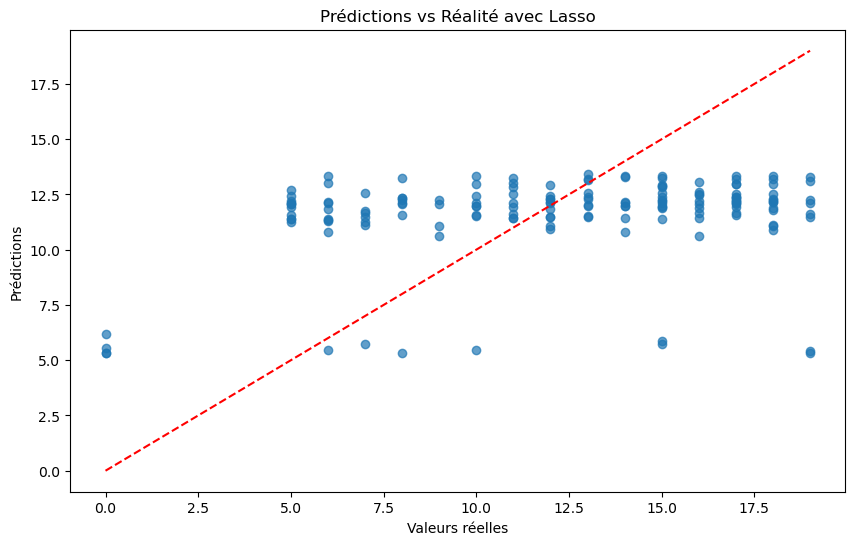

In [14]:
# Partie 6: Analyse du modèle et prédictions
print("\nExemple de prédiction pour un nouvel équipement:")

# Créer un DataFrame pour un nouvel équipement
new_equipment = pd.DataFrame({
    'Category': ['Conditionnement'],
    'Maintenance_Cycle': ['Mensuelle'],
    'Location': ['Sfax'],  # Ajusté pour correspondre aux données de formation
    'Energy_Type': ['Electricité'],
    'Maintenance_Frequency': ['Mensuel'],
    'CO2_Emissions_kg': [450.5],
    'Energy_Consumption_kWh': [2500.0]
})

# Faire une prédiction avec le meilleur modèle
predicted_lifetime = best_model.predict(new_equipment)
print(f"Durée de vie prédite pour le nouvel équipement: {predicted_lifetime[0]:.2f} années")

# Visualisation des prédictions vs réalité
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_model.predict(X_test), alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title(f'Prédictions vs Réalité avec {best_model_name}')
plt.show()

# Analyse de l'importance des caractéristiques pour RandomForest
if best_model_name == 'RandomForest':
    regressor = best_model.named_steps['regressor']
    feature_names = []
    
    # Obtenir les noms des caractéristiques après transformation
    # Pour les caractéristiques numériques
    feature_names.extend(numeric_features)
    
    # Pour les caractéristiques catégorielles encodées
    cat_encoder = best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder']
    if hasattr(cat_encoder, 'get_feature_names_out'):
        cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
        feature_names.extend(cat_feature_names)
    
    # Afficher l'importance des caractéristiques
    if hasattr(regressor, 'feature_importances_'):
        importances = regressor.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title('Importance des caractéristiques')
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), [feature_names[i] if i < len(feature_names) else f"Feature {i}" for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()
        
        print("\nLes 10 caractéristiques les plus importantes:")
        for i in range(min(10, len(indices))):
            feature_idx = indices[i]
            if feature_idx < len(feature_names):
                print(f"{feature_names[feature_idx]}: {importances[feature_idx]:.4f}")
            else:
                print(f"Feature {feature_idx}: {importances[feature_idx]:.4f}")

# Fermer la connexion à la base de données
conn.close()